# ACT coursework 2 question 1
## Decision Tree Classifier
In this notebook I will be providing a tutorial on how to create a Decision Tree Classifier and use that to predict whether or not a fusion experiment will result in ignition (i.e. whether or not it becomes self-sustaining).
I've chosen this method as this is, for all intents and purposes, an exercise into classifying data into "true" and "false" outputs, and because this is simply the quickest, easiest, and most understandable method of performing this task; using a random forest classifier would require first explaining how decision tree classifiers work, so it's generally a better idea to cut out the middle-man and go with the direct approach (that of course being using a DCT). 

## Libraries
The cell below shows what libraries are required to run the code in this notebook; some of these are direct imports of the full library, as denoted by beginning with 'import', whereas some are importing specific functions from libraries, as denoted by beginning with 'from' and following the library itself with 'import' and a number of functions.

In [1]:
#List of all libraries needed to run this code.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import SelectPercentile as SP
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
import kagglehub
from timeit import default_timer as timer

## Importing and loading data
This section imports the dataset directly from the Kaggle website and reads it into the notebook, then drops the 'Unnamed: 0' column as it's only for indexing and serves no use in anything we're doing.

In [2]:
#Defines the file path as the directory path from the website + the file name (as this is not included in the 
#directory path.
path = kagglehub.dataset_download("adebusayoadewunmi/nuclearfusion-data") + '/fusion_experiment.csv'
#Reads in the dataset and stores it under the variable 'fusion', then drops the 'Unnamed: 0' column and saves the 
#change to the dataframe.
fusion = pd.read_csv(path)
fusion = fusion.drop(['Unnamed: 0'], axis=1)
#Displaying the dataframe.
fusion

,Magnetic Field Fluctuations,Leakage,Instabilities,Plasma Instabilities,Magnetic Field Strength,Magnetic Field Configuration,Injection Energy,Beam Symmetry,Target Density,Target Composition,Fuel Density,Temperature,Confinement Time,Fuel Purity,Energy Input,Power Output,Pressure,Neutron Yield,Ignition
0,0.037454,0.058078,0.028259,0.015705,9.000578,tokamak,5.713125,0.800007,2.026963e+19,deuterium,7.612226e+19,4.050388e+08,0.842126,99.971295,250.726719,55.321517,6.107792e+06,5.443404e+10,0
1,0.095071,0.052697,0.045868,0.009551,3.841421,reversed field pinch,9.819548,0.082642,3.050685e+19,deuterium-tritium,8.742441e+19,2.551963e+08,0.504637,99.951049,345.614166,22.767959,4.921946e+06,8.372016e+10,0
2,0.073199,0.035104,0.009922,0.013794,1.467187,stellarator,7.016781,0.176319,5.287388e+19,tritium,8.236610e+19,2.627651e+08,0.357445,99.958831,290.050980,49.872944,9.798230e+06,8.112584e+10,1
3,0.059866,0.049321,0.044684,0.047349,9.277696,tokamak,4.018930,0.833709,5.961305e+19,deuterium-tritium,9.079654e+19,3.104709e+08,0.992195,99.997186,436.491093,2.656182,5.611293e+06,4.423307e+10,1
4,0.015602,0.036510,0.020308,0.088453,4.926347,reversed field pinch,6.145836,0.808161,7.887942e+19,deuterium,8.186142e+19,3.258529e+08,0.648677,99.927054,198.773196,48.096005,8.541064e+06,2.245276e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.079230,0.062215,0.009281,0.075015,6.989681,tokamak,8.363230,0.080241,6.220430e+19,deuterium-tritium,8.029543e+19,3.534515e+08,0.434566,99.917577,130.728901,51.822726,9.611845e+06,6.252602e+10,0
99996,0.077925,0.062922,0.062563,0.027253,9.904975,reversed field pinch,3.718771,0.977716,3.429971e+19,tritium,1.608651e+19,4.554238e+08,0.888713,99.902695,114.869008,9.746068,1.099463e+06,4.545773e+10,0
99997,0.067445,0.019220,0.062666,0.057559,5.389669,tokamak,8.788397,0.374680,4.750184e+19,tritium,3.021016e+19,2.331046e+08,0.323766,99.910285,458.044080,69.116870,7.473165e+06,7.240109e+10,0
99998,0.049945,0.065308,0.004765,0.089334,6.984881,tokamak,3.024949,0.926179,3.030606e+19,deuterium-tritium,4.217068e+19,2.660837e+08,0.646530,99.984932,342.844863,31.591851,6.759779e+06,7.576517e+10,0


## Data management
We want to make sure that everything will work properly with the Decision Tree Classifier, so for this we need to change any string values in the dataframe into numbers that can represent them *and* be readable by various other functions used later on. 

Additionally, to save on time and resources for the DCT, we want to "normalize" the data; this is the process of transforming it such that all values are between 0 and 1, as smaller data values will take less computational power and as such are quicker and easier to complete.

In [3]:
#Initialising a Label Encoder.
le = LabelEncoder()

#Fitting and transformingthe Magnetic Field Configuration and Target Composition columns to the Label Encoder so 
#that they are floats instead of strings, then saving the columns as the transformed columns.
fusion['Magnetic Field Configuration'] = le.fit_transform(fusion['Magnetic Field Configuration']).astype('float64')
fusion['Target Composition'] = le.fit_transform(fusion['Target Composition']).astype('float64')

#Displaying the dataframe so that we can see what it all looks like now and keep track of what string is now what
#float.
fusion

,Magnetic Field Fluctuations,Leakage,Instabilities,Plasma Instabilities,Magnetic Field Strength,Magnetic Field Configuration,Injection Energy,Beam Symmetry,Target Density,Target Composition,Fuel Density,Temperature,Confinement Time,Fuel Purity,Energy Input,Power Output,Pressure,Neutron Yield,Ignition
0,0.037454,0.058078,0.028259,0.015705,9.000578,2.0,5.713125,0.800007,2.026963e+19,0.0,7.612226e+19,4.050388e+08,0.842126,99.971295,250.726719,55.321517,6.107792e+06,5.443404e+10,0
1,0.095071,0.052697,0.045868,0.009551,3.841421,0.0,9.819548,0.082642,3.050685e+19,1.0,8.742441e+19,2.551963e+08,0.504637,99.951049,345.614166,22.767959,4.921946e+06,8.372016e+10,0
2,0.073199,0.035104,0.009922,0.013794,1.467187,1.0,7.016781,0.176319,5.287388e+19,2.0,8.236610e+19,2.627651e+08,0.357445,99.958831,290.050980,49.872944,9.798230e+06,8.112584e+10,1
3,0.059866,0.049321,0.044684,0.047349,9.277696,2.0,4.018930,0.833709,5.961305e+19,1.0,9.079654e+19,3.104709e+08,0.992195,99.997186,436.491093,2.656182,5.611293e+06,4.423307e+10,1
4,0.015602,0.036510,0.020308,0.088453,4.926347,0.0,6.145836,0.808161,7.887942e+19,0.0,8.186142e+19,3.258529e+08,0.648677,99.927054,198.773196,48.096005,8.541064e+06,2.245276e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.079230,0.062215,0.009281,0.075015,6.989681,2.0,8.363230,0.080241,6.220430e+19,1.0,8.029543e+19,3.534515e+08,0.434566,99.917577,130.728901,51.822726,9.611845e+06,6.252602e+10,0
99996,0.077925,0.062922,0.062563,0.027253,9.904975,0.0,3.718771,0.977716,3.429971e+19,2.0,1.608651e+19,4.554238e+08,0.888713,99.902695,114.869008,9.746068,1.099463e+06,4.545773e+10,0
99997,0.067445,0.019220,0.062666,0.057559,5.389669,2.0,8.788397,0.374680,4.750184e+19,2.0,3.021016e+19,2.331046e+08,0.323766,99.910285,458.044080,69.116870,7.473165e+06,7.240109e+10,0
99998,0.049945,0.065308,0.004765,0.089334,6.984881,2.0,3.024949,0.926179,3.030606e+19,1.0,4.217068e+19,2.660837e+08,0.646530,99.984932,342.844863,31.591851,6.759779e+06,7.576517e+10,0


In [4]:
#Normalizing data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(fusion)
fusion = pd.DataFrame(scaled_data, columns=fusion.columns)

## Feature Selection
Here, we do two things:

The first, as standard for all machine learning programs, is creating a train-test-split; in essence, we're splitting the data into "training" and "testing" data, which is to say we're splitting data into what we'll be using to train the model and what we'll be using to test it. 

Next, we'll use something called Mutual Information scores to decide what features from the dataset we want to use in training the model. For our model, we'll use features that are within the top 25th percentile of MI scores, as we want only the most relevant data to be used when we're training the model (this both saves time as the dataset will be smaller and *should* make the model more accurate as it's not taking in extraneous data).

In [21]:
#To create a train-test-split, we first set X as all of the data except for the 'Ignition' column, which we set as
#the "target" data; this is all to say that the model will be using X to try to predict y.
X, y = fusion.drop('Ignition', axis=1), fusion['Ignition']

#For this, we're creating a train and test set for both x and y, with the training set being 80% of the data in 
#the dataset and the remaining 20% being the testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#Saves the categorical columns for use later on, as they will most likely be removed from the dataset by the 
#feature selection.
mfc_train, targ_train = X_train['Magnetic Field Configuration'], X_train['Target Composition']
mfc_test, targ_test = X_test['Magnetic Field Configuration'], X_test['Target Composition']
#We initialise the selector here, setting it to the 25th percentile and above, then fit X_train and y_train to it.
selector = SP(percentile = 25)
selector.fit(X_train, y_train)
#We then update X_train and X_test so that they use just the columns dictated by the selector.
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

## Finding the best parameters for the model
As the title suggests, here we want to find the best parameters to use for our decision tree classifier. To do so, there are two approaches we can take:

- Grid search: This approach searches through a list of values for each parameter of the model, finding the best combination of parameters from each list. This approach is generally quicker as, if you're using it, you'll most likely have a good idea already of what parameters are best for the model and want to check between them.
- Randomized search: This approach randomly searches through a *range* of values instead of through a set list of values, going through a set number of iterations before stopping. Whilst this process usually takes longer than a grid search, it's better for getting parameters when you're not certain of what would be best for your dataset. 

We'll be using a RandomizedSearchCV to find the best parameters for our model, as this will be the easiest method for going in mostly blind.

In [6]:
#This initializes the model itself so that we can call and train it later on. Note that we use a specific random
#state for the sake of reproducability. 
clf = DecisionTreeClassifier(random_state=42)

#This is a list containing the parameters and the ranges that we want to explore; We've only chosen these three
#parameters as they generally contribute the most to a DTC model's accuracy.
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

#Here we are initializing the random search function, setting it to perform the search using the clf model, the
#list of parameter ranges described above, 50 iterations, the cross validation strategy, the metric by which it
#will be judging the best parameters (in this case the accuracy of the model), and finally the random state is set
#to a specific value for the sake of reproducability. We then fit X_train and y_train to this search.
random_search = RandomizedSearchCV(estimator=clf,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42)
random_search.fit(X_train, y_train)

#Saves the best parameters of the model and then saves the best model as best_params and best_model respectively.
best_params = random_search.best_params_
best_model = random_search.best_estimator_

#Uses the prediction of y from the best model to test its accuracy, then prints it.
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 11}
Best Model Accuracy: 0.7002


## Model initialization and fitting
This is most likely the simplest part of the notebook: Here, all we're doing is taking the output of the best parameters and using them to fit the model to the data, using the same random state we used when originally initializing the model for the random search.

In [7]:
#Creating the model again with the best parameters and fitting the data to it.

clf = DecisionTreeClassifier(max_depth=1, min_samples_leaf=5, min_samples_split=11, random_state=42)
start = timer()
clf.fit(X_train_selected, y_train)
end = timer()
print(f'Training time: {end-start} seconds')

Training time: 0.10345785692334175 seconds


## Model Evaluation

## Model accuracy
The quickest and easiest way to evaluate a model is by looking at its accuracy score; this is essentually just looking at how often the model correctly predicts a result, in this case correctly predicting a 1 or a 0. For this, we ideally want a score as close to 1 as possible.
Additionally, it's a good idea to look at the mean-squared-error of the prediction. This is, as the name implies, the average squared error rate of the prediction against the training results. 

In [8]:
#Testing accuracy of the model
clf_train_accuracy = clf.score(X_train_selected, y_train)
clf_test_accuracy = clf.score(X_test_selected, y_test)
clf_train_pred = clf.predict(X_train_selected)
mse = mean_squared_error(y_train, clf_train_pred)
print(f'Train accuracy: {clf_train_accuracy*100:.2f}%')
print(f'Test accuracy: {clf_test_accuracy*100:.2f}%')
print(f"Mean Squared Error: {mse}")

Train accuracy: 69.85%
Test accuracy: 70.02%
Mean Squared Error: 0.30151428571428573


### Classification report
From hereon out we'll be evaluating the model in a number of different ways, the first of which is with a classification report; classification reports are easy ways of getting all the information we need in one function, providing four things:
- Precision: Checks the prediction of the model again the test set to see how often it gets a prediction correct.
- Recall: Checks how many of the predicted positives were *actually* positive.
- F1-score: The harmonic mean of precision and recall useful for imbalanced classes.
- Support: The number of occurrences of each class in the dataset.

In [9]:
y_train = np.array(y_train)

In [10]:
#Testing accuracy of the model
clf_train_pred = clf.predict(X_train_selected)
clf_test_pred = clf.predict(X_test_selected)
train_class_report = classification_report(y_train, clf_train_pred)
test_class_report = classification_report(y_test, clf_test_pred)
print("Training classification Report:\n", train_class_report)
print("\n")
print("Testing classification report: \n", test_class_report)

Training classification Report:
               precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     48894
         1.0       0.00      0.00      0.00     21106

    accuracy                           0.70     70000
   macro avg       0.35      0.50      0.41     70000
weighted avg       0.49      0.70      0.57     70000



Testing classification report: 
               precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     21006
         1.0       0.00      0.00      0.00      8994

    accuracy                           0.70     30000
   macro avg       0.35      0.50      0.41     30000
weighted avg       0.49      0.70      0.58     30000



/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

We see here that while the model *technically* has a decent accuracy score, this is because it's predicting only zeroes and no ones; seeing this is quite important to understanding the flaws inherent in this method of prediction. We can go into this further by looking at the visualisation of the decision tree itself:

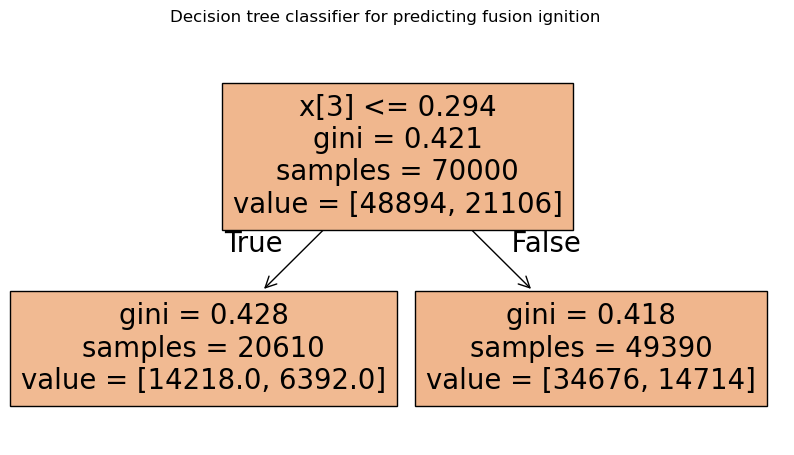

In [11]:
#Plotting the tree
fig = plt.figure(figsize=(10, 5))
plt.suptitle(f"Decision tree classifier for predicting fusion ignition")
tree.plot_tree(clf, filled=True)
plt.show()
fig.clear()

This tree shows us the logic that's going into the model; a decision tree classifier works by splitting data between a number of blocks, then outputs the maximum of the 'value' array. Here we see that, in both of the blocks generated by clf, the higher value is the one corresponding to zero. This is most likely due to the fact that there is a large class imbalance in the data, meaning that with a tree this shallow, we're bound to only get an output of zero. 


Moving on, it's usually a good idea to plot feature importances for a Decision Tree, as this gives us an idea of what features of the training data are contributing most to the final decision made by the tree. 

Text(0, 0.5, 'Importance score')

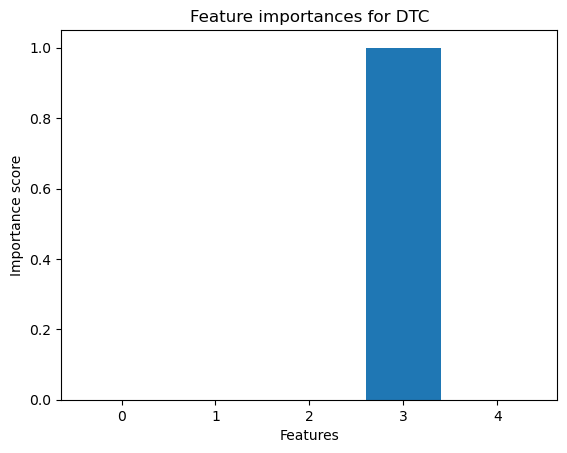

In [12]:
#Plotting feature importances

importances = clf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature importances for DTC")
plt.xlabel('Features')
plt.ylabel('Importance score')

Unfortunately we can't plot this based on the *exact* features used for the data as we don't know what those features are, thanks to the Mutual Information selector we used earlier. 
Regardless, we see here that the third selected feature is given 100% importance; this is most likely why the model is performing so poorly and not generating any realistically usable results - it's not actually taking into consideration all of the data it's being supplied with, so it's coming to the wrong conclusions. 

## Initial conclusions

To round all of this off, the decision tree classifier, as it is, is quite ineffective in actually predicting a fusion result. This is mostly due to a combination of the shallowness of the model, how decision trees select outputs, and the class imbalance inherent to the dataset. There is also the issue of the Randomized Search working off of accuracy instead of precision or recall, hence why whilst it provides parameters for a reasonable accurate model, the model itself is not actually precise at all. 

## Model improvements
Let's consider what's going wrong here; with a very shallow tree and a highly imbalanced target dataset, the model we've been using can't make any accurate predictions. Fortunately, there are a few ways that we can improve the precision and recall of the model, with the two most notable being as follows:
- Increase the depth of the tree so that more data splits are performed, thus allowing for ones to potentially be generated in predictions.
- Perform a random undersampling on the data; this is the process of going through the data and deleting random rows of data containing the 'major class' in a target column, i.e. the class that appears the most often in that column. In the case of this dataset, we would be deleting random rows of Ignition=0 data, balancing the classes somewhat and making the model less overfitted to the major class. 

### Deeper tree
Below are three different models, each with all the same parameters as the original excluding the maximum depth of the tree, which we're increasing with each subsequent model. As we can see from each of their respective classification reports, it appears that predictions of 1s start occurring once the model has at least a max depth of three, but there's seemingly a problem with the recall not working due to not being able to interpret missing data entries. I'm not entirely sure how to fix this, but regardless, the result seems to be that deeper trees are better at predicting ignition.

In [23]:
clf_2 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=11, random_state=42)
clf_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=11, random_state=42)
clf_4 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=11, random_state=42)
clf_5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=11, random_state=42)

clf_2.fit(X_train_selected, y_train)
clf_3.fit(X_train_selected, y_train)
clf_4.fit(X_train_selected, y_train)
clf_5.fit(X_train_selected, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=11,
                       random_state=42)

In [24]:
clf_2_accuracy = clf_2.score(X_train_selected, y_train)
clf_3_accuracy = clf_3.score(X_train_selected, y_train)
clf_4_accuracy = clf_4.score(X_train_selected, y_train)
clf_5_accuracy = clf_5.score(X_train_selected, y_train)

print(f'2 accuracy: {clf_2_accuracy*100:.2f}%')
print(f'3 accuracy: {clf_3_accuracy*100:.2f}%')
print(f'4 accuracy: {clf_4_accuracy*100:.2f}%')
print(f'5 accuracy: {clf_5_accuracy*100:.2f}%')


2 accuracy: 69.85%
3 accuracy: 69.85%
4 accuracy: 69.85%
5 accuracy: 69.90%


In [25]:
clf_2_pred = clf_2.predict(X_train_selected)
clf_3_pred = clf_3.predict(X_train_selected)
clf_4_pred = clf_4.predict(X_train_selected)
clf_5_pred = clf_5.predict(X_train_selected)


clf_2_class_report = classification_report(y_train, clf_2_pred)
clf_3_class_report = classification_report(y_train, clf_3_pred)
clf_4_class_report = classification_report(y_train, clf_4_pred)
clf_5_class_report = classification_report(y_train, clf_5_pred)

print("2 classification Report:\n", clf_2_class_report)
print("3 classification Report:\n", clf_3_class_report)
print("4 classification Report:\n", clf_4_class_report)
print("5 classification Report:\n", clf_5_class_report)


/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

2 classification Report:
               precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     48894
         1.0       0.00      0.00      0.00     21106

    accuracy                           0.70     70000
   macro avg       0.35      0.50      0.41     70000
weighted avg       0.49      0.70      0.57     70000

3 classification Report:
               precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     48894
         1.0       0.00      0.00      0.00     21106

    accuracy                           0.70     70000
   macro avg       0.35      0.50      0.41     70000
weighted avg       0.49      0.70      0.57     70000

4 classification Report:
               precision    recall  f1-score   support

         0.0       0.70      1.00      0.82     48894
         1.0       0.51      0.00      0.00     21106

    accuracy                           0.70     70000
   macro avg       0.60      0.50      0.41     70

As we can see from each of their respective classification reports, it appears that predictions of 1s still isn't possible with the data the models are receiving. It's likely that even with the deeper trees, the dataset is too small for the model to make an accurate prediction.

#### Random Undersampling
Below is some code to randomly undersample the training data and then fit it to the original model and the new ones with higher max depths.

There's something interesting going on here, in that the classification report shows the precision and recall of the model still has high recall for zeroes and close to zero for ones, except in the fourth model in which the opposite is true. Precision across the board has become more evenly split between the two classes except for, model three, which has the ones class with a precision .22 higher than that of the zeroes class. The reason behind this isn't clear to me, as I have no way of knowing why this is happening. 

In [29]:
from imblearn.under_sampling import RandomUnderSampler 
#Much like an ML model, we initialise the random sampler such that it can reshape data to reduce the target; in
#this case, the target is the 'majority' of the Ignition column. 
rus = RandomUnderSampler(sampling_strategy = 'majority',
                                         random_state=42)
X, y = fusion.drop('Ignition', axis=1), fusion['Ignition']
#X and y are now reshaped to remove excessive results of zeroes, becoming X_rs and y_rs. 
#We then use these to make a train-test-split and fit the five models to that data.
X_rs, y_rs = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size = 0.3, random_state=42)
clf.fit(X_train, y_train)
clf_2.fit(X_train, y_train)
clf_3.fit(X_train, y_train)
clf_4.fit(X_train, y_train)
clf_5.fit(X_train, y_train)


/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/idies/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=11,
                       random_state=42)

In [30]:
clf_pred = clf.predict(X_train)
clf_2_pred = clf_2.predict(X_train)
clf_3_pred = clf_3.predict(X_train)
clf_4_pred = clf_4.predict(X_train)
clf_5_pred = clf_5.predict(X_train)

clf_class_report = classification_report(y_train, clf_pred)
clf_2_class_report = classification_report(y_train, clf_2_pred)
clf_3_class_report = classification_report(y_train, clf_3_pred)
clf_4_class_report = classification_report(y_train, clf_4_pred)
clf_5_class_report = classification_report(y_train, clf_5_pred)

print("Classification Report 1:\n", clf_2_class_report)
print("Classification Report 2:\n", clf_2_class_report)
print("Classification Report 3:\n", clf_3_class_report)
print("Classification Report 4:\n", clf_4_class_report)
print("Classification Report 5:\n", clf_5_class_report)

Classification Report 1:
               precision    recall  f1-score   support

         0.0       0.50      0.99      0.67     21129
         1.0       0.58      0.01      0.02     21011

    accuracy                           0.50     42140
   macro avg       0.54      0.50      0.34     42140
weighted avg       0.54      0.50      0.34     42140

Classification Report 2:
               precision    recall  f1-score   support

         0.0       0.50      0.99      0.67     21129
         1.0       0.58      0.01      0.02     21011

    accuracy                           0.50     42140
   macro avg       0.54      0.50      0.34     42140
weighted avg       0.54      0.50      0.34     42140

Classification Report 3:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     21129
         1.0       0.72      0.01      0.01     21011

    accuracy                           0.50     42140
   macro avg       0.61      0.50      0.34     42

Let's also plot feature importance for each of these models to see what features are contributing the most in each. 

<function matplotlib.pyplot.show(close=None, block=None)>

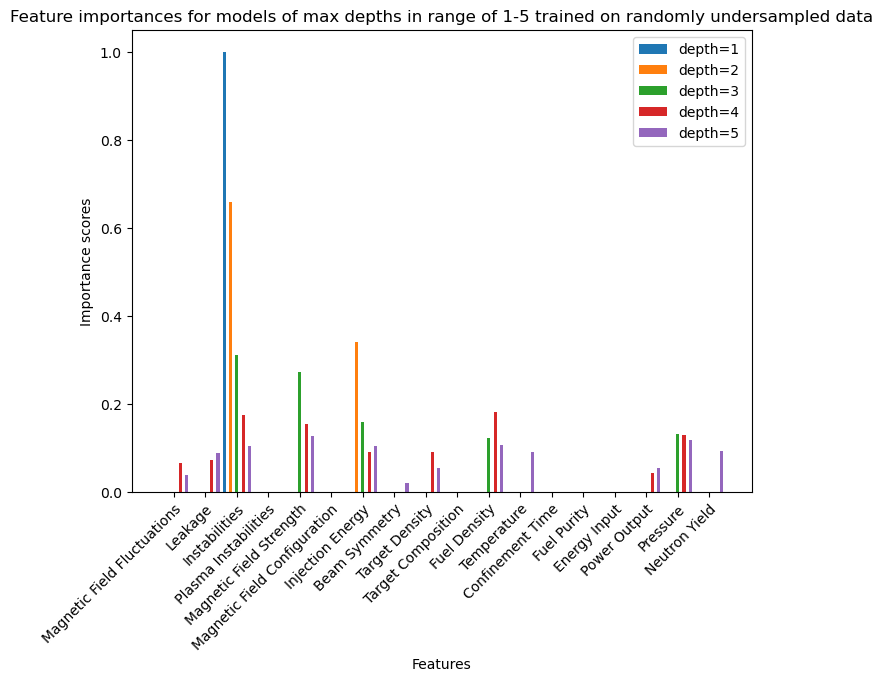

In [31]:
features = list(X_train.columns)
x = np.arange(len(features))

clf_importances =  clf.feature_importances_
clf_2_importances = clf_2.feature_importances_
clf_3_importances = clf_3.feature_importances_
clf_4_importances = clf_4.feature_importances_
clf_5_importances = clf_5.feature_importances_

bar_width = 0.1

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x-0.4, clf_importances, width = bar_width, label = 'depth=1')
ax.bar(x-0.2, clf_2_importances, width = bar_width, label = 'depth=2')
ax.bar(x, clf_3_importances, width = bar_width, label = 'depth=3')
ax.bar(x+0.2, clf_4_importances, width = bar_width, label = 'depth=4')
ax.bar(x+0.4, clf_5_importances, width = bar_width, label = 'depth=5')
plt.legend()
plt.xticks(x, features)
ax.set_xticklabels(features, rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Features')
plt.ylabel('Importance scores')
plt.title('Feature importances for models of max depths in range of 1-5 trained on randomly undersampled data')
plt.show

There are a number of things we can glean from looking at this:

- The number of features considered by the model increases with its depth, with the first model have only one feature being considered and the fifth model considering 12 features.
- Models don't start using the 'magnetic field fluctuations' and 'leakage' data until the fourth one onwards. 
- Beam symmetry, target composition, confinement time, fuel purity, and energy input are all ignored by every single model.

To sum it all up, I believe that the innaccuracy of the model stems from it not properly considering all the data available to it. Let's try taking it all the way to the more extreme end and create a model with a max depth of 80, then look at the results.

Model training accuracy: 86.51%
Model testing accuracy: 49.82%
Mean squared error: 0.13488372093023257
Classification report 80:
               precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     21129
         1.0       0.87      0.85      0.86     21011

    accuracy                           0.87     42140
   macro avg       0.87      0.87      0.87     42140
weighted avg       0.87      0.87      0.87     42140



<function matplotlib.pyplot.show(close=None, block=None)>

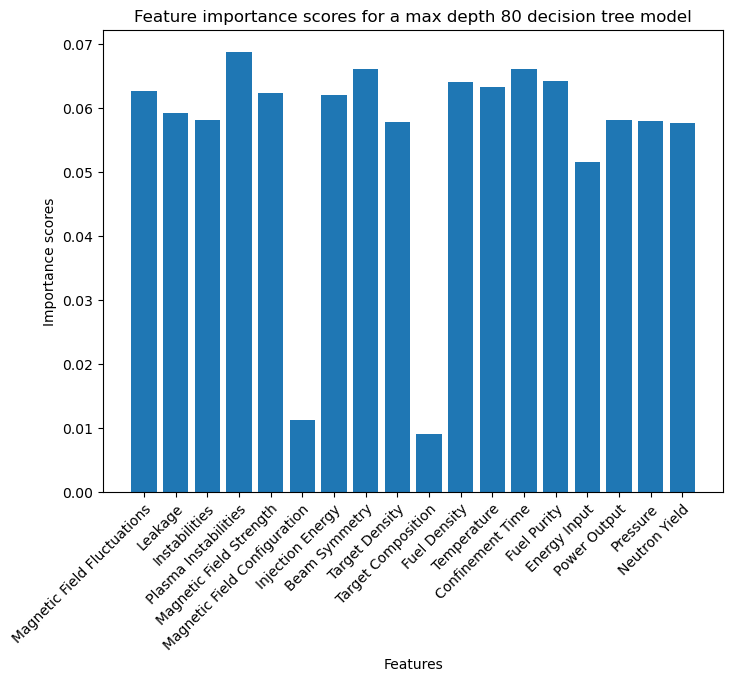

In [37]:
clf_80 = DecisionTreeClassifier(max_depth=80, min_samples_leaf=5, min_samples_split=11, random_state=42)

clf_80.fit(X_train, y_train)

clf_80_pred = clf_80.predict(X_train)
clf_80_pred_test = clf_80.predict(X_test)
clf_80_tr_accuracy = accuracy_score(y_train, clf_80_pred)
clf_80_te_accuracy = accuracy_score(y_test, clf_80_pred_test)
clf_80_mse = mean_squared_error(y_train, clf_80_pred)
clf_80_class_report = classification_report(y_train, clf_80_pred)
print(f'Model training accuracy: {clf_80_tr_accuracy*100:.2f}%')
print(f'Model testing accuracy: {clf_80_te_accuracy*100:.2f}%')
print(f'Mean squared error: {clf_80_mse}')
print("Classification report 80:\n", clf_80_class_report)

clf_80_importances = clf_80.feature_importances_


fig, ay = plt.subplots(figsize=(8, 6))
plt.bar(x, clf_80_importances)
plt.xticks(x, features)
ay.set_xticklabels(features, rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Features')
plt.ylabel('Importance scores')
plt.title('Feature importance scores for a max depth 80 decision tree model')
plt.show

Now we can see that the precision, recall, and F1 scores of the model are both a lot higher and more balanced than that of the model we first made; this goes to show that max depth is seemingly the parameter with the highest correlation with the actual accuracy of the model. 
There's also something to be said about what we've learnt with not immediately trusting the accuracy score of a model; because these models score accuracy based on the number of correct predictions, which can be skewed by data being generated in unexpected ways (in this case, the model being unable to predict anything other than the dominant class of the target data). It's best to use precision and recall scores to determine how well a model predicts this target data so that our understanding of its accuracy is clearer. 

## Closing remarks
To round things off, let's go over what we've learnt from all this:
For this dataset, a Decision Tree Classifier is quite successful at predicting fusion ignition. The task we're performing here is, for all intents and purposes, a classification task of true or false, and so it makes sense that this type of classifier works well on it. 
As we've seen, we must take into account the imbalance present in the dataset when training models so as to not overfit it to predicting the majority class, and we must take into account the sheer size of the data when selecting the maximum depth of the model as a low-depth model will not be able to split data enough to make any realistic predictions.

In the next notebook, I'll be performing the same task with a neural-net approach, then comparing that approach with this one. 